# Projekt Uczenie Maszynowe na systemach wbudowanych

## Odczytywanie liczb w systemie rzymskich i konwersja na arabskie

Kinga Miszczak, Katarzyna Such

In [1]:
import cv2
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

Pomocniczy słownik ze wszystkimi literami alfabetu dla wzoru

In [2]:
word_dict = {
    0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F',
    6:'G', 7:'H', 8:'I', 9:'J', 10:'K', 11:'L',
    12:'M', 13:'N', 14:'O', 15:'P', 16:'Q', 17:'R',
    18:'S', 19:'T', 20:'U', 21:'V', 22:'W', 23:'X',
    24:'Y', 25:'Z'
}

### Sieć neuronowa

Na początku wczytałyśmy dane. Zdecydowałyśmy się tutaj na zbiór danych zawierający obrazy z napisanymi na nich odręcznie pojedyczymi literami. Przyświecała nam tutaj idea, że jeśli sieć będzie w stanie poradzić sobie z rozpoznawaniem liter odręcznych to bez problemu poradzi sobie z typowymi dla rzymskimiego systemu zapisu drukowanymi literami.

Z istotnych rzeczy, które dzieją się w komórce poniżej możemy zobaczyć, że zachowujemy tutaj jedynie litery, które występują w cyfrach rzymskich (zobacz słownik word_dict). Znacząco poprawia to rozpozanie liczb rzymskich, ale też odbiera możliwośc dodatkowej, potencjalnej weryfikacji, czy dany napis w ogóle jest liczbą rzymską.

In [3]:
data = pd.read_csv("A_Z Handwritten Data.csv").astype('float32')
data = data[data['0'].isin([2, 3, 8, 11, 12, 21, 23])]

Następnie dokonujemy podziału na zbiór wartości i etykiet

In [4]:
X = data.drop('0',axis = 1)
y = data['0']

Kolejny krok: podział danych na zbióry trenujący oraz testujący zgodnie z regułą pareto czyli 4:1

In [5]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2)
train_x = np.reshape(train_x.values, (train_x.shape[0], 28,28))
test_x = np.reshape(test_x.values, (test_x.shape[0], 28,28))

Rozmiary poszczególnych zbiorów

In [6]:
print("Train data shape: ", train_x.shape)
print("Test data shape: ", test_x.shape)

Train data shape:  (55231, 28, 28)
Test data shape:  (13808, 28, 28)


Postanowiłyśmy również dla zobrazowania pokazać jak wygląda rozkład poszczególnych liter w uzyskanym po przetwarzaniu zbiorze danych

C:\Users\User\AppData\Local\Temp\ipykernel_4420\3050976030.py:2: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  for i in np.int0(y):


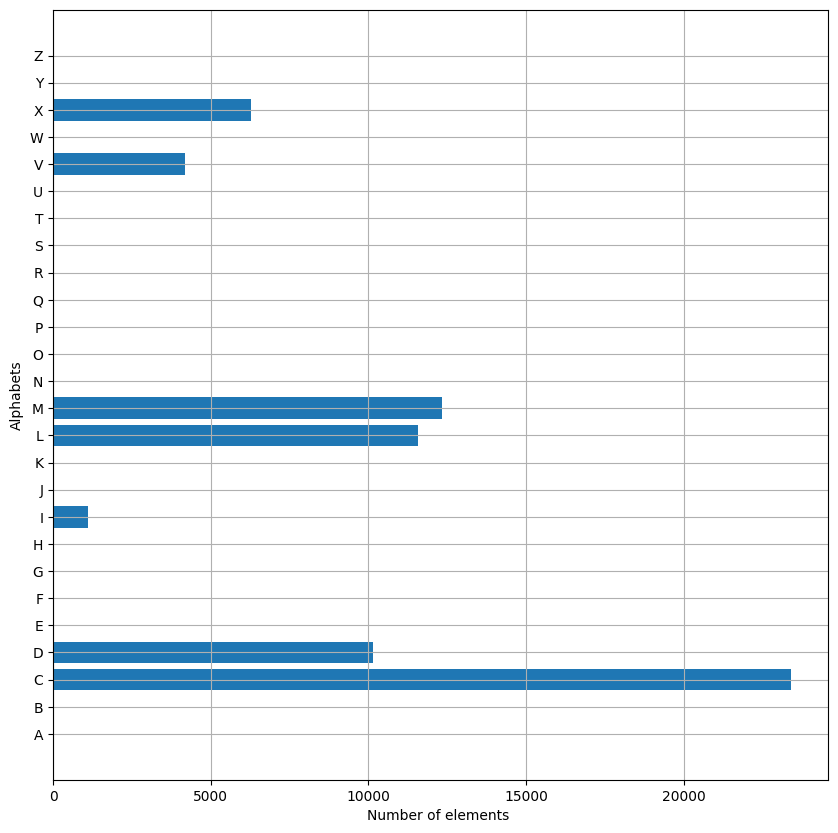

In [7]:
count = np.zeros(26, dtype='int')
for i in np.int0(y):
    count[i] +=1

alphabets = [i for i in word_dict.values()]

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.barh(alphabets, count)

plt.xlabel("Number of elements ")
plt.ylabel("Alphabets")
plt.grid()
plt.show()

Widzimy pewne niezbalansowanie w danych. Nie okazało się to mieć dużego wpływu na uczenie, jednak miało później duże znaczenie dla wyników.

Ostatnie zobrazowanie przed trenowaniem przedstawia kilka z elementów ze zbioru danych

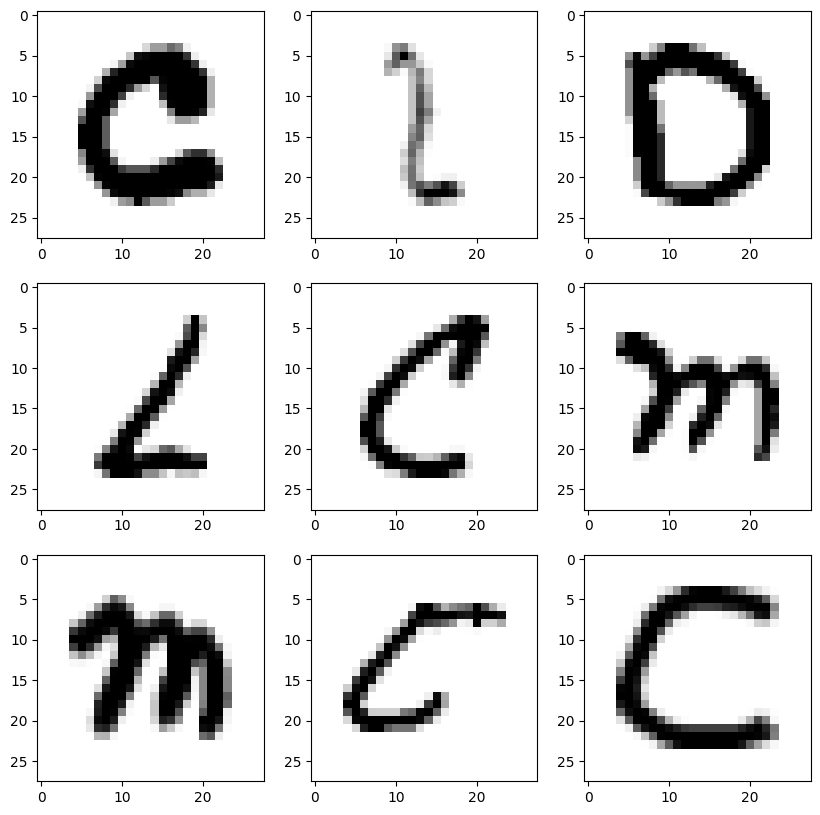

In [8]:
fig, ax = plt.subplots(3,3, figsize = (10,10))
axes = ax.flatten()

for i in range(9):
    axes[i].imshow(np.reshape(train_x[i], (28,28)), cmap="Greys")
plt.show()

W celu wykorzystania naszych danych w późniejszym modelu koniecznym okazały się pewne zmiany kształtów przedstawione poniżej.

In [9]:
train_X = train_x.reshape(train_x.shape[0],train_x.shape[1],train_x.shape[2],1)
print("New shape of train data: ", train_X.shape)

test_X = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2],1)
print("New shape of train data: ", test_X.shape)

New shape of train data:  (55231, 28, 28, 1)
New shape of train data:  (13808, 28, 28, 1)


Następnie zmieniłyśmy etykiety (wektor liczb całkowitych) w zbiorze na macierz binarną reprezentującą kategorie.

In [10]:
train_yOHE = to_categorical(train_y, num_classes = 26, dtype='int')
print("New shape of train labels: ", train_yOHE.shape)

test_yOHE = to_categorical(test_y, num_classes = 26, dtype='int')
print("New shape of test labels: ", test_yOHE.shape)

New shape of train labels:  (55231, 26)
New shape of test labels:  (13808, 26)


W ten sposób sprowadziłyśmy wszystkie cechy tylko do 26 klas (liter)

Wszystkie te operacje prowadziły nas do modelu sieci neuronowej, który miał rozwiązać nasz problem i który prezentuje się następująco.

In [11]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))

model.add(Dense(26,activation ="softmax"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

Model został następnie skompilowany i wytrenowany

In [13]:
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [14]:
history = model.fit(train_X, train_yOHE, epochs=5, callbacks=[reduce_lr, early_stop],  validation_data = (test_X,test_yOHE))

Epoch 1/5
1726/1726 [==============================] - 43s 24ms/step - loss: 0.1217 - accuracy: 0.9766 - val_loss: 0.0296 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 2/5
1726/1726 [==============================] - 37s 21ms/step - loss: 0.0271 - accuracy: 0.9915 - val_loss: 0.0220 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 3/5
1726/1726 [==============================] - 36s 21ms/step - loss: 0.0221 - accuracy: 0.9930 - val_loss: 0.0218 - val_accuracy: 0.9925 - lr: 0.0010
Epoch 4/5
1726/1726 [==============================] - 35s 21ms/step - loss: 0.0186 - accuracy: 0.9937 - val_loss: 0.0221 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 5/5
1726/1726 [==============================] - 37s 22ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.0116 - val_accuracy: 0.9967 - lr: 2.0000e-04


Zdecydowałyśmy się także na zachowanie modelu do pliku, dzięki czemu nie trzeba było go potem trenować na nowo

In [15]:
model.save(r'model_hand1.h5')

Dokładność wytrenowanego modelu prezentuje się następująco

In [16]:
print("The validation accuracy is :", history.history['val_accuracy'])
print("The training accuracy is :", history.history['accuracy'])
print("The validation loss is :", history.history['val_loss'])
print("The training loss is :", history.history['loss'])

The validation accuracy is : [0.9905127286911011, 0.9932647943496704, 0.9925405383110046, 0.9935544729232788, 0.9966685771942139]
The training accuracy is : [0.9766254425048828, 0.9915083646774292, 0.9930473566055298, 0.9937353730201721, 0.998424768447876]
The validation loss is : [0.02963908575475216, 0.02195218950510025, 0.0218074731528759, 0.02210279554128647, 0.011637227609753609]
The training loss is : [0.12166489660739899, 0.027107130736112595, 0.022103555500507355, 0.018566565588116646, 0.005167084746062756]


Ukończywszy trenowanie możemy sprawdzić jak prezentują się wyniki na kilku przykładach ze zbioru

In [17]:
pred = model.predict(test_X[:9])

1/1 [==============================] - 0s 109ms/step


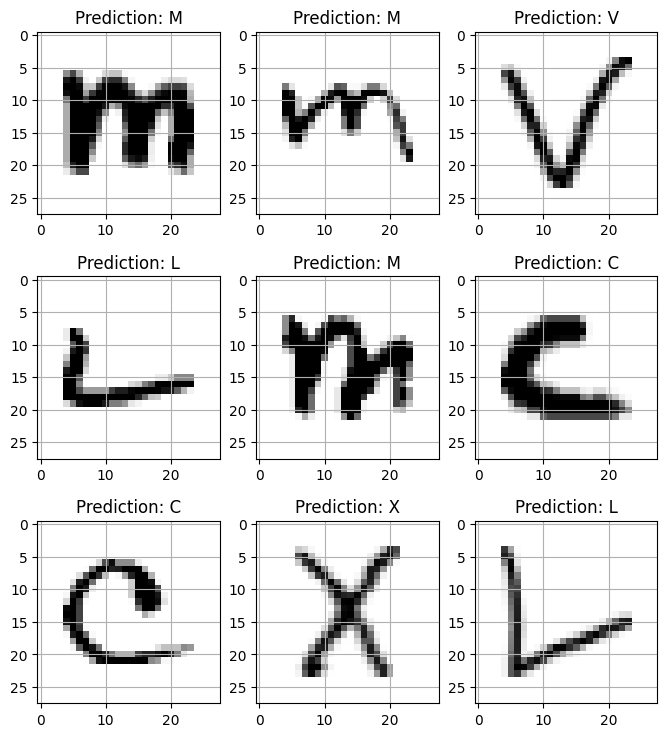

In [18]:
fig, axes = plt.subplots(3,3, figsize=(8,9))
axes = axes.flatten()

for i,ax in enumerate(axes):
    img = np.reshape(test_X[i], (28,28))
    ax.imshow(img, cmap="Greys")
    pred = word_dict[np.argmax(test_yOHE[i])]
    ax.set_title("Prediction: "+pred)
    ax.grid()

Jak możemy zauważyć wszystkie rezultaty są poprawne co też nie powinno dziwić, gdyż dokładność modelu osiągna aż 99%.

Koniecznym jest jednak dodatkowo sprawdzić działanie modelu na obrazku, którego ten wcześniej nie widział. Poniżej prezentujemy taki przykład i ponownie uzyskujemy poprawną predykcję.

1/1 [==============================] - 0s 149ms/step


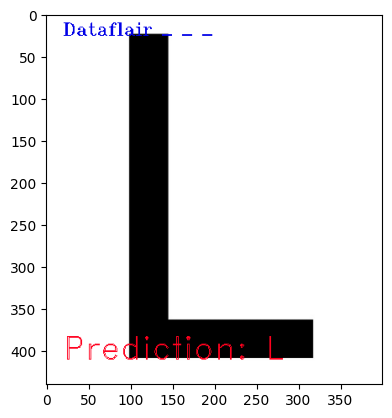

In [19]:
img = cv2.imread(r"test_images/L.jpg")
img_copy = img.copy()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (400,440))

img_copy = cv2.GaussianBlur(img_copy, (7,7), 0)
img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
_, img_thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)

img_final = cv2.resize(img_thresh, (28,28))
img_final =np.reshape(img_final, (1,28,28,1))

img_pred = word_dict[np.argmax(model.predict(img_final))]

cv2.putText(img, "Dataflair _ _ _ ", (20,25), cv2.FONT_HERSHEY_TRIPLEX, 0.7, color = (0,0,230))
cv2.putText(img, "Prediction: " + img_pred, (20,410), cv2.FONT_HERSHEY_DUPLEX, 1.3, color = (255,0,30))
plt.imshow(img)

### Analiza obrazów

W założeniach projektu przyjęłyśmy założenie, że rozpoznajemy po jednej literze. Koniecznym więc było, aby w wypadku występowania na obrazie więcej niż jednej litery dokonać ekstrakcji pojedynczych liter (wyciąć je w postaci mniejszych obrazków), aby następnie na ich podstawie dokonywać predykcji. Do tego celu posłużyła przede wszystkim analiza obrazów, a konkretnie narzędzie OpenCV.

In [20]:
def _apply_thresh(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  thresh = cv2.adaptiveThreshold(blurred, 50,
  cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 45, 15)
  return thresh

def _get_upper_and_lower_thresh_bounds(image):
  total_pixels = image.shape[0] * image.shape[1]
  lower = total_pixels // 250
  upper = total_pixels // 1
  return lower, upper


def _is_background_label(label):
  return label == 0


def _consturct_label_mask(thresh ,labels, current_label):
  labelMask = np.zeros(thresh.shape, dtype="uint8")
  labelMask[labels == current_label] = 255
  return labelMask


def compare(rect1, rect2):
    if abs(rect1[0] - rect2[0]) > 10:
        return rect1[0] - rect2[0]
    else:
        return rect1[1] - rect2[1]


def _prepare_bounding_boxes(mask):
  cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  boundingBoxes = [cv2.boundingRect(c) for c in cnts]
  return sorted(boundingBoxes, key=functools.cmp_to_key(compare) )


def _extract_images_with_individual_letters(thresh, boundingBoxes):
  frag = thresh.copy()
  images = []
  for box in boundingBoxes:
    x, y, w, h = box

    letter_image = frag[y:y+h, x:x+w]
    letter_image = cv2.copyMakeBorder(
        letter_image, 5, 5, 7, 7, cv2.BORDER_CONSTANT, (0, 0, 0))
    letter_image = cv2.resize(letter_image, (28,28))
    letter_image =np.reshape(letter_image, (1,28,28,1))
    images.append(letter_image)
  return images


def _prepare_final_number(images_to_predict):
  result = ''
  for img in images_to_predict:
    predicted_letter = word_dict[np.argmax(model.predict(img))]
    result+=predicted_letter
  return result


def get_number_from_image(image):
  thresh = _apply_thresh(image)

  _, labels = cv2.connectedComponents(thresh)
  mask = np.zeros(thresh.shape, dtype="uint8")

  lower, upper = _get_upper_and_lower_thresh_bounds(image)

  for (i, label) in enumerate(np.unique(labels)):
    if _is_background_label(label):
        continue
    labelMask = _consturct_label_mask(thresh, labels, label)
    numPixels = cv2.countNonZero(labelMask)
    if numPixels > lower and numPixels < upper:
        mask = cv2.add(mask, labelMask)

  masked = cv2.bitwise_and(thresh, thresh, mask=mask)

  boundingBoxes = _prepare_bounding_boxes(mask)
  images_to_predict = _extract_images_with_individual_letters(thresh,
                                                              boundingBoxes)
  result = _prepare_final_number(images_to_predict)

  return result

Poniżej kilka testów działania funkcji, którą mamy powyżej

In [21]:
def plot_image(image):
  plt.imshow(image)
  plt.show()

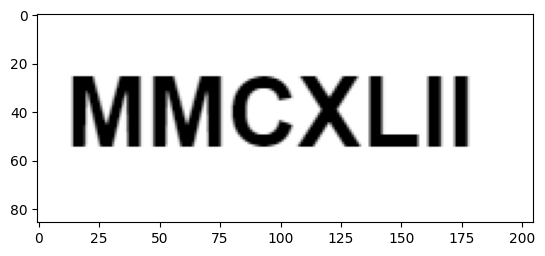

1/1 [==============================] - 0s 22ms/step
MMCXLDD


In [22]:
image = cv2.imread("C:/Users/User/Desktop/SEM1/UM/UM_Systemy_Wbudowane/test_images/word2.png")
plot_image(image)
print(get_number_from_image(image))

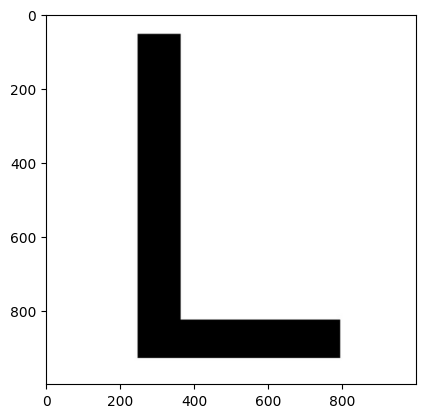

1/1 [==============================] - 0s 25ms/step
L


In [23]:
image = cv2.imread("test_images/L.jpg")
plot_image(image)
print(get_number_from_image(image))

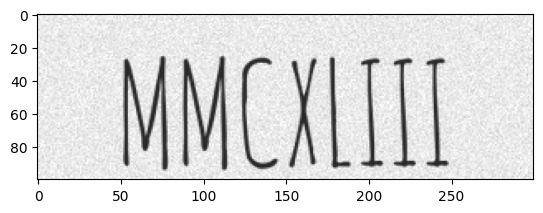

1/1 [==============================] - 0s 23ms/step
MMCXLIII


In [24]:
image = cv2.imread("test_images/mmcxliii.png")
plot_image(image)
print(get_number_from_image(image))

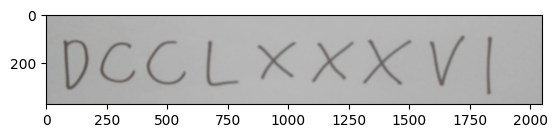

1/1 [==============================] - 0s 23ms/step
DCCLXXXVI


In [25]:
image = cv2.imread("test_images/dcclxxxvi.jpg")
plot_image(image)
print(get_number_from_image(image))

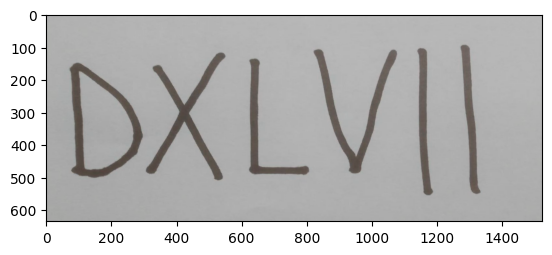

1/1 [==============================] - 0s 24ms/step
DXLVLD


In [26]:
image = cv2.imread("test_images/dxlvii.jpg")
plot_image(image)
print(get_number_from_image(image))

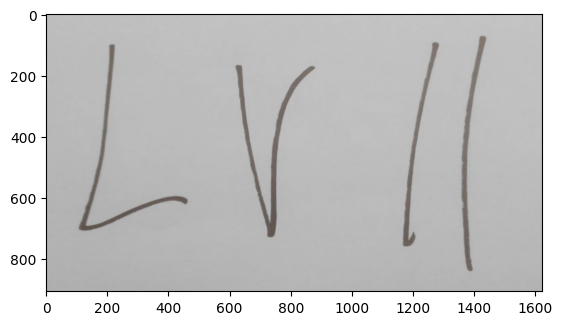

1/1 [==============================] - 0s 25ms/step
LVCC


In [27]:
image = cv2.imread("test_images/lvii.jpg")
plot_image(image)
print(get_number_from_image(image))

Niestety jak możemy zauważyć nie zawsze rozpoznanie jest w pełni poprawne. Model ma zwłaszcza problem z rozpoznaniem I, co wynika zapewne z niewielkiej ilości tej litery w porównaniu z innymi w zbiorze danych

### Konwersja

Ostatnią i najprostszą fazą była konwersja otrzymanego w ten sposób napisu na liczbę arabską, co zostało osiągnięte za pomocą następującego prostego algorytmu

In [28]:
def roman_to_arabic(roman_numeral):
    roman_map = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500,'M': 1000}

    result = 0
    previous_value = 0
    for char in reversed(roman_numeral):
        current_value = roman_map[char]
        if current_value >= previous_value:
            result += current_value
        else:
            result -= current_value
        previous_value = current_value
    return result

Przykład działania algorytmu

In [29]:
roman_numeral = 'MCMXCIV'
arabic_numeral = roman_to_arabic(roman_numeral)
print(arabic_numeral)

1994


### Finalny rezultat

Ostateczny program prezentuje się w następujący sposób

In [30]:
def process_image(image):
  plot_image(image)

  roman_numeral = get_number_from_image(image)
  arabic_numeral = roman_to_arabic(roman_numeral)
  print(arabic_numeral)

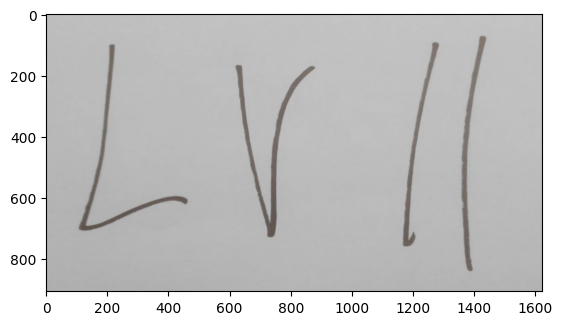

1/1 [==============================] - 0s 24ms/step
245


In [31]:
image = cv2.imread("test_images/lvii.jpg")
process_image(image)

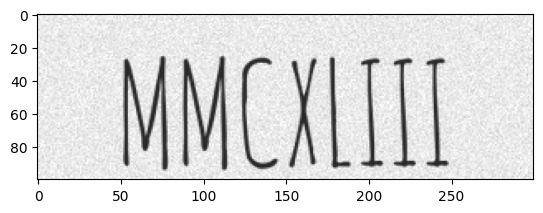

1/1 [==============================] - 0s 22ms/step
2143


In [32]:
image = cv2.imread("test_images/mmcxliii.png")
process_image(image)